In [3]:
import scipy.io
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
class WaterQualityDataset(Dataset):
    def __init__(self, mat_file, train=True, transform=None):
        """
        Args:
            mat_file (str): Path to the .mat file containing the dataset.
            train (bool): If True, load training data; otherwise load test data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Load the .mat file
        data = scipy.io.loadmat(mat_file)
        self.transform = transform

        # Process location group information
        # location_group is a 1x3 cell array: each cell contains the indices of stations in that group
        location_group = data['location_group']  # shape: (1, 3)
        location_ids = data['location_ids'].flatten()  # shape: (37,)
        num_stations = len(location_ids)  # should be 37

        # Create an array to store the group ID for each station
        group_ids = np.zeros(num_stations, dtype=np.float32)
        for i in range(location_group.shape[1]):
            # Each cell contains an array of station indices (MATLAB indices are 1-based)
            station_indices = location_group[0, i].flatten() - 1  # convert to 0-based index
            group_ids[station_indices] = i + 1  # assign group number (1, 2, 3)

        self.group_ids = group_ids

        # Load training or testing data based on flag
        if train:
            X_data = data['X_tr']  # shape: (1, 423), each cell is 37x11
            Y_data = data['Y_tr']  # shape: (37, 423)
        else:
            X_data = data['X_te']  # shape: (1, 282), each cell is 37x11
            Y_data = data['Y_te']  # shape: (37, 282)

        # Convert cell arrays into lists for easier iteration
        self.X_list = [X_data[0, i] for i in range(X_data.shape[1])]
        self.Y_list = [Y_data[:, i] for i in range(Y_data.shape[1])]

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        # Get input and target: X shape (37, 11), Y shape (37,)
        x = self.X_list[idx]
        y = self.Y_list[idx]

        # Convert to torch tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        # Build column vector of group IDs (shape: (37,) -> (37, 1))
        group_col = torch.tensor(self.group_ids, dtype=torch.float32).unsqueeze(1)
        # Concatenate group info to original features -> new shape (37, 12)
        x = torch.cat((x, group_col), dim=1)

        # Add channel dimension for CNN input -> final shape (1, 37, 12)
        x = x.unsqueeze(0)

        if self.transform:
            x = self.transform(x)

        return x, y

In [6]:
class WaterQualityTransformer(nn.Module):
    def __init__(self, feature_dim=12, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super(WaterQualityTransformer, self).__init__()

        # Input projection: (feature_dim) -> (d_model)
        self.input_proj = nn.Linear(feature_dim, d_model)

        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, 37, d_model))  # (batch, seq_len, d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output projection: (d_model) -> (1 value per station)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        # x shape: (batch_size, 1, 37, 12)
        batch_size = x.size(0)

        x = x.squeeze(1)  # remove channel dimension -> (batch_size, 37, 12)

        x = self.input_proj(x)  # -> (batch_size, 37, d_model)
        x = x + self.positional_encoding  # Add positional encoding

        x = self.transformer_encoder(x)  # -> (batch_size, 37, d_model)

        x = self.output_proj(x)  # -> (batch_size, 37, 1)
        x = x.squeeze(-1)  # -> (batch_size, 37)

        return x

In [7]:
def visualize_predictions(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        # Get a random batch from the test set
        sample_x, sample_y = random.choice(list(test_loader))
        sample_x = sample_x.to(device)
        sample_y = sample_y.to(device)
        predictions = model(sample_x)
        
        # Convert predictions and true values to numpy arrays
        predictions_np = predictions.cpu().numpy()
        true_np = sample_y.cpu().numpy()
    
    # Print comparison for the first sample in the batch
    print("Comparison for the first sample in the batch:")
    for station_idx in range(true_np.shape[1]):
        print(f"Station {station_idx+1:2d}: True = {true_np[0, station_idx]:.4f}, Predicted = {predictions_np[0, station_idx]:.4f}")
    
    # Plot the true vs. predicted values for the first sample
    plt.figure(figsize=(10, 5))
    plt.plot(true_np[0], label="True", marker='o')
    plt.plot(predictions_np[0], label="Predicted", marker='x')
    plt.title("True vs Predicted Water Quality Values")
    plt.xlabel("Station Index")
    plt.ylabel("Water Quality (pH)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
# File path for the dataset
mat_file_path = 'water_dataset.mat'

# Load dataset
train_dataset = WaterQualityDataset(mat_file_path, train=True)
test_dataset = WaterQualityDataset(mat_file_path, train=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WaterQualityTransformer().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
# Train
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

# Evaluate
model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

Epoch [1/20], Train Loss: 0.0482
Epoch [2/20], Train Loss: 0.0067
Epoch [3/20], Train Loss: 0.0045
Epoch [4/20], Train Loss: 0.0036
Epoch [5/20], Train Loss: 0.0030
Epoch [6/20], Train Loss: 0.0025
Epoch [7/20], Train Loss: 0.0022
Epoch [8/20], Train Loss: 0.0018
Epoch [9/20], Train Loss: 0.0016
Epoch [10/20], Train Loss: 0.0014
Epoch [11/20], Train Loss: 0.0013
Epoch [12/20], Train Loss: 0.0013
Epoch [13/20], Train Loss: 0.0011
Epoch [14/20], Train Loss: 0.0010
Epoch [15/20], Train Loss: 0.0009
Epoch [16/20], Train Loss: 0.0009
Epoch [17/20], Train Loss: 0.0008
Epoch [18/20], Train Loss: 0.0008
Epoch [19/20], Train Loss: 0.0008
Epoch [20/20], Train Loss: 0.0008
Test Loss: 0.0009


Comparison for the first sample in the batch:
Station  1: True = 0.6481, Predicted = 0.6706
Station  2: True = 0.6481, Predicted = 0.6791
Station  3: True = 0.6481, Predicted = 0.6787
Station  4: True = 0.6759, Predicted = 0.6847
Station  5: True = 0.6852, Predicted = 0.6922
Station  6: True = 0.6481, Predicted = 0.6683
Station  7: True = 0.6574, Predicted = 0.6740
Station  8: True = 0.6759, Predicted = 0.7083
Station  9: True = 0.7130, Predicted = 0.7231
Station 10: True = 0.6574, Predicted = 0.6566
Station 11: True = 0.6667, Predicted = 0.6690
Station 12: True = 0.6759, Predicted = 0.6807
Station 13: True = 0.6667, Predicted = 0.6734
Station 14: True = 0.6481, Predicted = 0.6650
Station 15: True = 0.6481, Predicted = 0.6568
Station 16: True = 0.6852, Predicted = 0.6852
Station 17: True = 0.6759, Predicted = 0.6690
Station 18: True = 0.7222, Predicted = 0.6927
Station 19: True = 0.6759, Predicted = 0.6795
Station 20: True = 0.6574, Predicted = 0.6556
Station 21: True = 0.6481, Predict

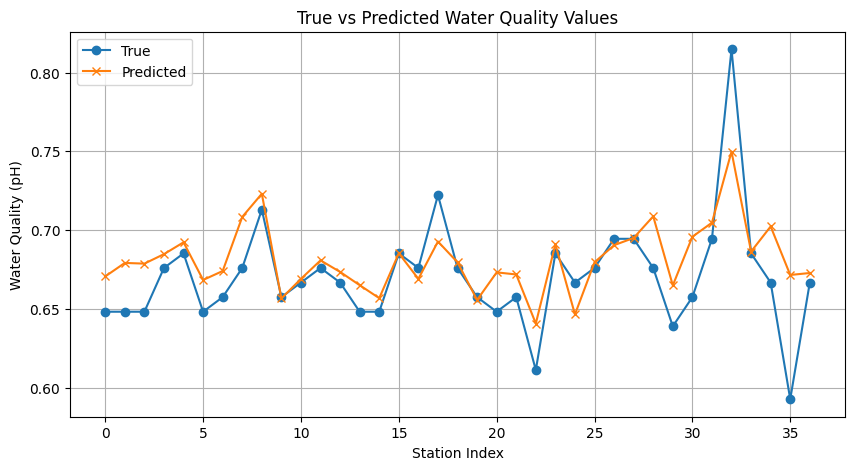

In [14]:
visualize_predictions(model, test_loader, device)